### Introduction:

### Data and Methods Used:

#### Data

The data we employed for this analysis includes house price data, socio-economic data and school data for the London region.

The house price data, consolidated by the UCL Centre for Advanced Spatial Analysis (Chi et al., 2019), contains information such as the house price, date of sale, type of property, size of property, number of rooms and geographic location. The London School dataset, which was acquired from the London Schools Atlas (London Datastore, 2016), an open government datastore, contains spatial information about primary and secondary schools in the greater London area. Since this school data was collected in 2016, a subset of the London house price data was extracted for houses sold in 2017. The London borough boundaries were sourced from the London_boroughs.geojson file (London Datastore, 2011). In addition, the Output Area file  (London Datastore, 2011) was also utilised in this analysis to provide socio-economic information for output areas in London such as the population density, proportion of students and density of trees. 

In [1]:
# Import required packages
import matplotlib as mpl
from matplotlib import colors

%matplotlib inline
mpl.rcParams['figure.figsize'] = (15, 10) #this increases the inline figure size to 15 tall x 10 wide

import seaborn
import pandas as pd
import geopandas as gpd
import pysal
import numpy as np
import mapclassify
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # Change settings so that warnings are not displayed


from shapely.geometry import Polygon
import plotly.express as px
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from splot.esda import plot_local_autocorrelation
from splot.esda import lisa_cluster
from esda.moran import Moran_Local

# Loading a few new packages
from scipy import stats
from pysal.model import spreg
import statsmodels.formula.api as sm

In [2]:
#Import datasets 
hp = gpd.read_file('C:/Users/zoewa/OneDrive/Documents/Data Masters/Data Analytics Project (module)/Project/houses_lr(1).geojson')
oa = gpd.read_file('C:/Users/zoewa/OneDrive/Documents/Data Masters/Data Analytics Project (module)/Project/OutputAreas.geojson')
lb = gpd.read_file('C:/Users/zoewa/OneDrive/Documents/Data Masters/Data Analytics Project (module)/Project/london_boroughs.geojson')
schools = gpd.read_file('C:/Users/zoewa/OneDrive/Documents/Data Masters/Data Analytics Project (module)/Project/all_schools_xy_2016(1).csv')

In [3]:
from pyproj import CRS, Transformer

#### Data Preparation

Several steps were taken to prepare the data for linear regression. Firstly, the coordinates of schools from the 2016 dataset were converted into a point geometry format compatible with the Coordinate Reference System (CRS) of the house price data from 2017. Subsequently, the minimum distance from each house to the nearest school was computed and these distance values were then merged back into the house price dataset. With the aim to employ a linear regression model for the prediction of house price, the natural logarithm of the floor area and house price was taken to address their right-skewed distributions. Binary variables were also created to represent property types (Detached and Flats) and whether the property was newly built (New). These variables, along with the log-transformed area, were included as covariates for further analysis.

In [4]:
#Converting coordinates in school dataset to a point geom in the same CRS as house price data and then calculating distance
from shapely.geometry import Point

hp17 = hp[(hp["year"]==2017)] #going for 2017 since our schools dataset is from 2016

crs_27700 = CRS("EPSG:27700")
crs_4326 = CRS("EPSG:4326")

transformer = Transformer.from_crs(crs_4326, crs_27700, always_xy=True)
schools['geometry'] = [Point(transformer.transform(lon, lat)) for lon, lat in zip(schools['x'], schools['y'])]

#Now calculate distance
hp_school_dist = hp17.geometry.apply(lambda x: schools.distance(x).min())

#Merge distances back into hp dataset
hp_with_school_dist = pd.concat([hp17, hp_school_dist.rename("Dist_School")], axis=1)

hp_with_school_dist = gpd.GeoDataFrame(hp_with_school_dist, geometry='geometry', crs=hp17.crs)

# Export the final dataset with calculated distance variables to a new GeoJSON file
hp_with_school_dist.to_file("houses_with_school_distance.geojson", driver='GeoJSON', schema={"geometry": "Point", "properties": {"postcode": "str", "price": "float", "dateoftransfer": "str", "propertytype": "str", "oldnew": "str", "duration": "str", "categorytype": "str", "recordstatus": "str", "year": "float", "tfarea": "float", "numberrooms": "float", "priceper": "float", "pcd": "str", "pcd2": "str", "dointr": "float", "doterm": "float", "Dist_School": "float"}})



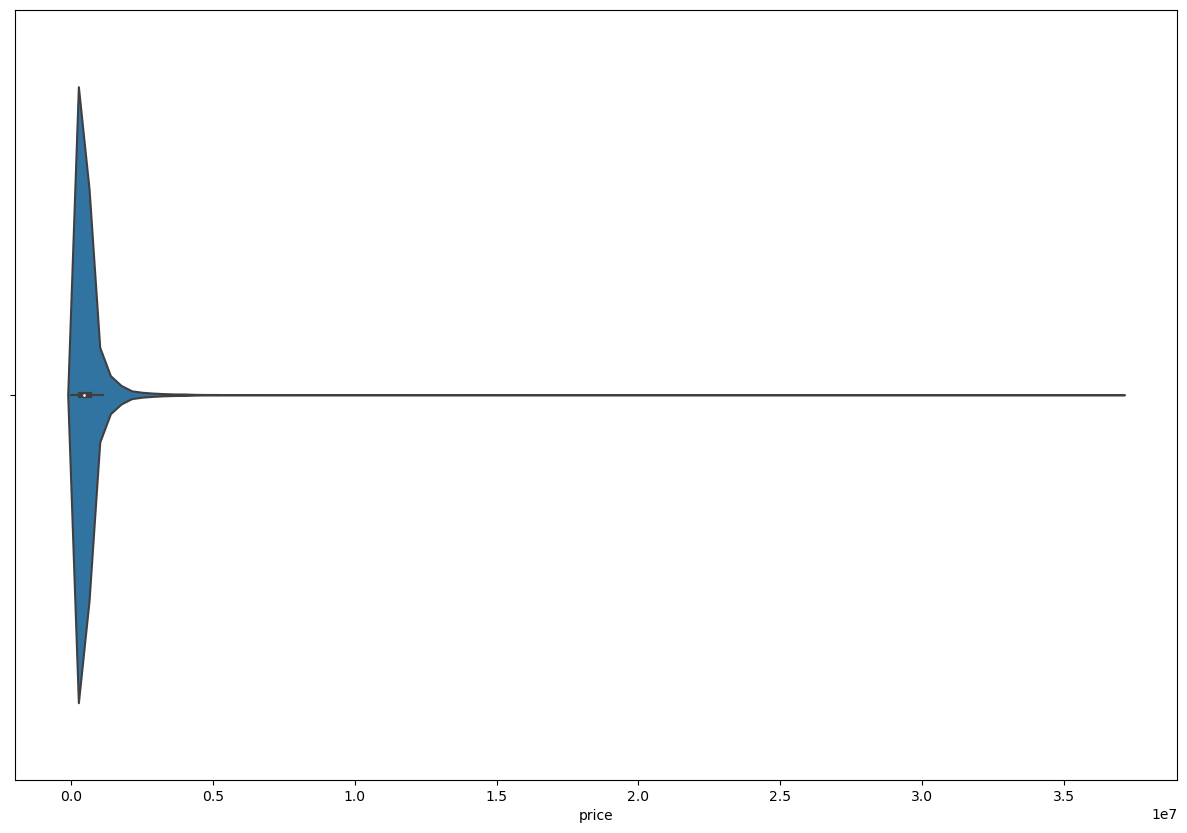

In [106]:
bx = seaborn.violinplot(x=hp_with_school_dist['price'])

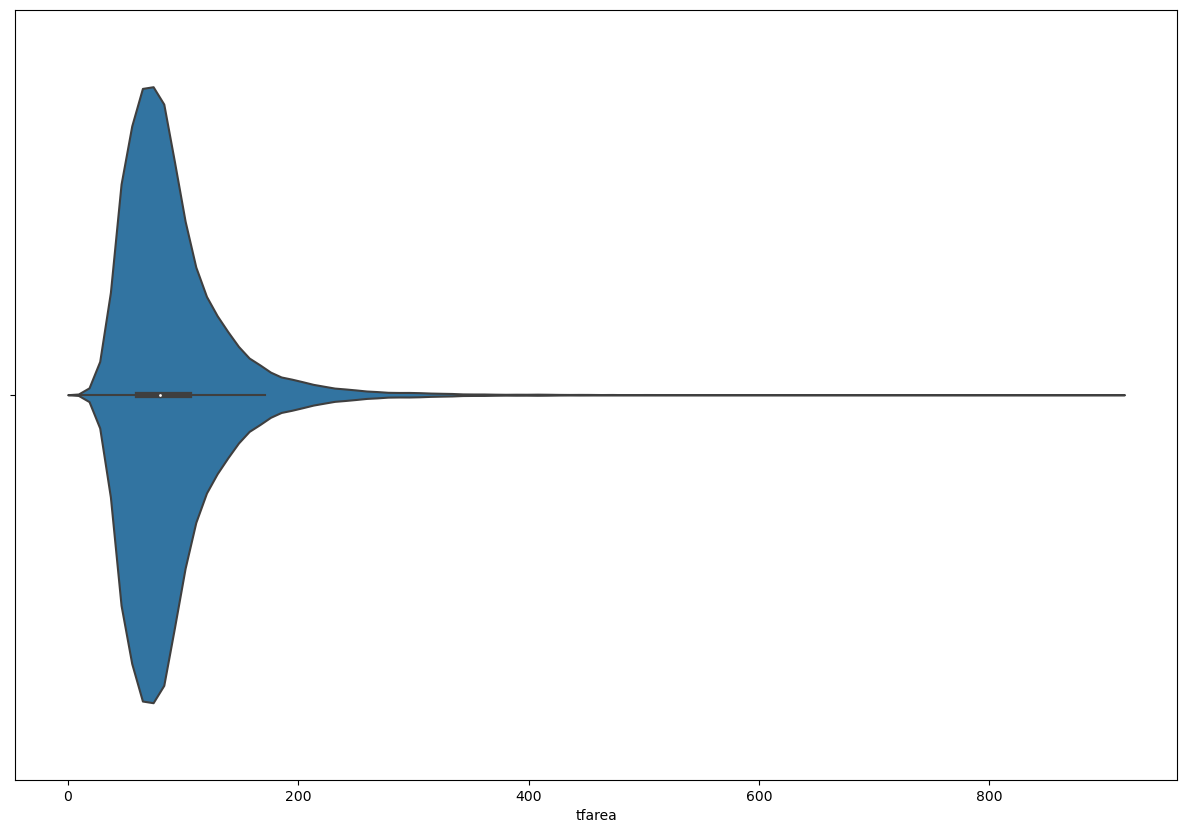

In [107]:
bx = seaborn.violinplot(x=hp_with_school_dist['tfarea'])

In [6]:
#take the natural log of area and price as these are both right skewed
hp_with_school_dist['log_area'] = np.log(hp_with_school_dist['tfarea'])
hp_with_school_dist['log_price'] = np.log(hp_with_school_dist['price'])

In [7]:
#Need to create binary variables for property type and old/new
hp_with_school_dist['Detached'] = np.where(hp_with_school_dist['propertytype']=='D', 1, 0)
hp_with_school_dist['Flats'] = np.where(hp_with_school_dist['propertytype']=='F', 1, 0)
hp_with_school_dist['New'] = np.where(hp_with_school_dist['oldnew']=='Y', 1, 0)

#list of covariates
variable_names = ['log_area', 'numberrooms', 'Flats', 'Detached','New']

#### Model Development 

The initial stage of model development involved constructing a non-spatial regression model between the (log-transformed) house price and key housing characteristics including (log-transformed) floor area, the number of rooms, property type, and a binary indicator for whether the property was newly built. It is assumed that these characteristics have a significant influence on the price of a house. 


In [8]:
#First regression with only the covariates above 
model1 = spreg.OLS(hp_with_school_dist[['log_price']].values, hp_with_school_dist[variable_names].values,
                name_y='log_price', name_x=variable_names, robust='white')
print(model1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       63501
Mean dependent var  :     13.1055                Number of Variables   :           6
S.D. dependent var  :      0.5654                Degrees of Freedom    :       63495
R-squared           :      0.5336
Adjusted R-squared  :      0.5336
Sum squared residual:     9466.14                F-statistic           :  14529.6318
Sigma-square        :       0.149                Prob(F-statistic)     :           0
S.E. of regression  :       0.386                Log likelihood        :  -29672.198
Sigma-square ML     :       0.149                Akaike info criterion :   59356.395
S.E of regression ML:      0.3861                Schwarz criterion     :   59410.748

White Standard Errors
--------------------------------------

In [111]:
#Interpreting the coefficients - log(tfarea) 
#For a 10% increase in floor area
(1.1)**(1.01693) - 1

0.10177639428916785

In [108]:
#Interpreting the coefficients - Flats
np.exp(0.15929) - 1


0.17267797398683138

In [109]:
#Interpreting the coefficients - Detached
np.exp(0.02161) - 1

0.02184518712602923

In [110]:
#Interpreting the coefficients - New
np.exp(0.38647) - 1

0.47177624311678623

The R-squared value tells us the percentage of overall variance in Y explained by our covariates. In this case, it is 0.53 which shows that just over half of the variance in house prices can be explained by these housing characteristics.  The coefficients of the variables suggest their respective impacts on house prices. Notably, the (log-transformed) floor area exhibits a positive association with the (log-transformed) house price. This indicates that as the floor area increases by 10%, house prices are expected to increase by 10.2%. Similarly, properties classified as flats also show a positive association with house prices. This model predicts that house prices are 17.6% higher for flats compared to other house types, when all other factors in the model are held constant. Detached properties exhibit a smaller positive impact as the price of detached houses are expected to be 2.2% higher compared to other types. Additionally, new properties are predicted to have prices that are 47.2% higher than older properties. As shown by the p-values, these variables are all statistically significant. However, the number of rooms does not appear to have a statistically significant relationship with house prices in this model. 

The Jarque-Bera statistic is commonly applied in regression analysis to evaluate the normality of residuals. This model has a high Jarque-Bera statistic along with a low p-value, which suggests that the residuals deviate significantly from a normal distribution.

By visualising the spatial distribution of the model errors, we can infer whether spatial structures play a significant role in determining variations in house prices beyond the housing characteristics included in the initial model. A clear pattern in the residual plot, such as clustering, suggests the presence of spatial processes influencing house prices.



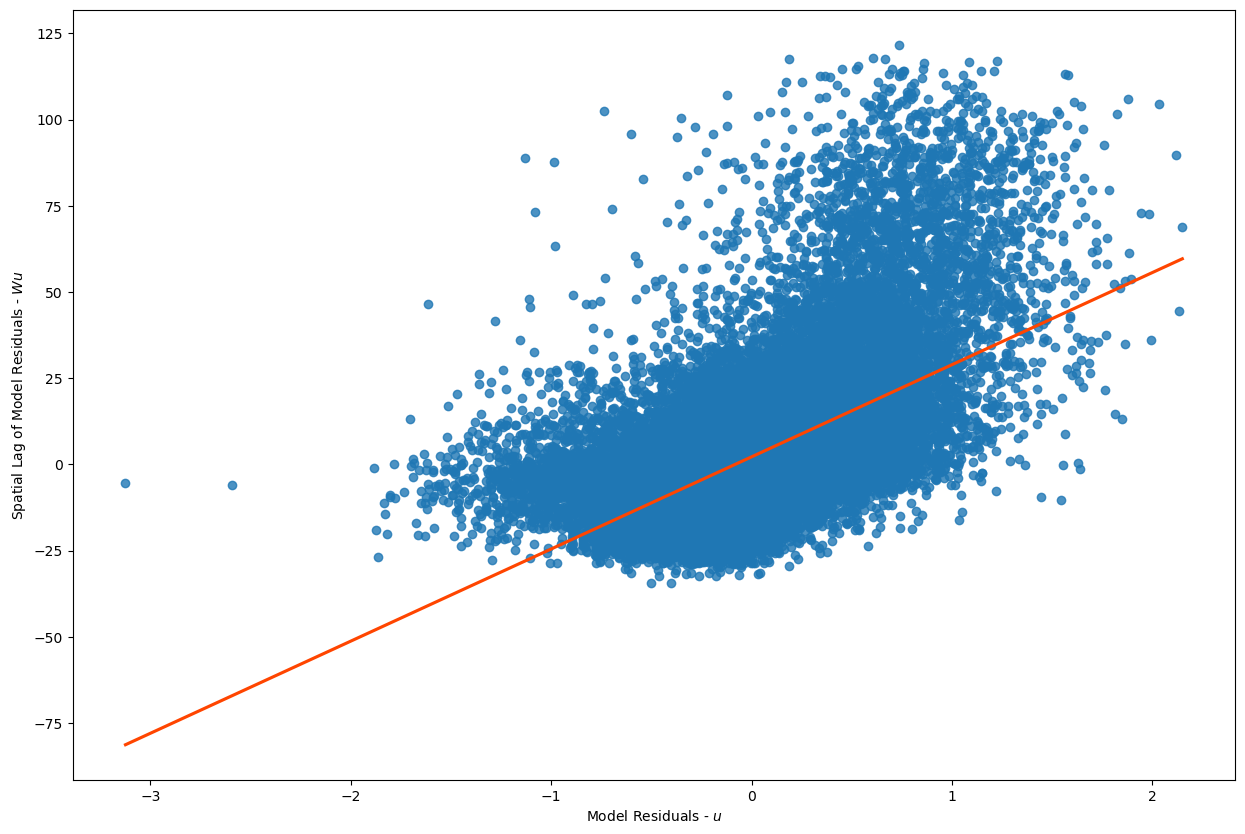

In [115]:
#Lets look at clustering in the model errors by neighbourhood. 

hp_with_school_dist2 = gpd.sjoin(hp_with_school_dist, oa)
pd.set_option('display.max_columns', None)

w = weights.DistanceBand.from_dataframe(hp_with_school_dist2, 500) # Weights based on features within 500 meters

#then correlate these spatially-lagged residuals with the residuals of the model in their origin locations:
lag_residual = weights.spatial_lag.lag_spatial(w, model1.u)
ax = seaborn.regplot(
    x=model1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color='orangered'),
    ci=None,
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

This plot shows a strong positive correlation which implies that neighbouring houses tend to exhibit similar prices. This clustering of residuals is a violation of the OLS assumption that errors are independent. The presence of this spatial clustering suggests that there are spatial processes influencing the relationships between the selected housing characteristics for the prediction of house prices. To address this, a fixed effects model was next employed. This involves incorporating dummy variables into the model to represent each borough with the aim to capture the spatially structured nature of the house price dynamics. 

In [12]:
fixedmodel = 'log_price ~ ' + ' + '.join(variable_names) + ' + NAME_2 - 1' # Remove intercept (-1) in this fixed effects model

model2 = sm.ols(fixedmodel, data=hp_with_school_dist2).fit()
print(model2.summary2())

                        Results: Ordinary least squares
Model:                  OLS                  Adj. R-squared:         0.774     
Dependent Variable:     log_price            AIC:                    13197.1187
Date:                   2024-04-02 12:50     BIC:                    13541.0556
No. Observations:       63005                Log-Likelihood:         -6560.6   
Df Model:               37                   F-statistic:            5827.     
Df Residuals:           62967                Prob (F-statistic):     0.00      
R-squared:              0.774                Scale:                  0.072149  
-------------------------------------------------------------------------------
                                Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
NAME_2[Barking and Dagenham]    9.2994   0.0190 489.3606 0.0000  9.2621  9.3366
NAME_2[Barnet]                  9.7918   0.0190 514.2953 0.0000 

Model 2, shows a significant improvement in explanatory power compared to model 1, with an adjusted R-squared value of 0.774. The introduction of dummy variables representing each borough directly into the model appears to capture significant spatial variations in house prices across London. Distinct and significant coefficients for each borough reflect the varying house prices associated with each location. Notably, flats now have a negative correlation with house price when neighbourhood is taken into account. This is likely because the price premiums associated with flats in central areas are offset by lower prices and different market dynamics in other neighbourhoods.

Model 2 highlights the importance of considering spatial context when interpreting the relationship between housing characteristics and prices in London. Accounting for neighbourhood effects, such as amenities and proximity to key infrastructure, allow us to gain a deeper insight into the spatial nature of property values. In this study, we are particularly interested in investigating the impact of proximity to schools on house prices. This can be done by incorporating a spatial proximity measure into our regression model. 



In [15]:
base_names = variable_names
dist_names = variable_names + ['Dist_School']

In [16]:
model3 = spreg.OLS(hp_with_school_dist2[['log_price']].values, hp_with_school_dist2[dist_names].values,
                name_y='log_price', name_x=dist_names, robust='white')
print(model3.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:       63501
Mean dependent var  :     13.1055                Number of Variables   :           7
S.D. dependent var  :      0.5654                Degrees of Freedom    :       63494
R-squared           :      0.5486
Adjusted R-squared  :      0.5486
Sum squared residual:     9161.44                F-statistic           :  12862.5012
Sigma-square        :       0.144                Prob(F-statistic)     :           0
S.E. of regression  :       0.380                Log likelihood        :  -28633.371
Sigma-square ML     :       0.144                Akaike info criterion :   57280.741
S.E of regression ML:      0.3798                Schwarz criterion     :   57344.153

White Standard Errors
--------------------------------------

Explain summary of Model 3 here

Explain Spatial Lag of X Model (SLX) here (why it could improve from model 3) 



In [17]:
wx = hp_with_school_dist2[variable_names].apply(
    lambda y: weights.spatial_lag.lag_spatial(w, y)
# Rename the spatial lag, adding w_ to the original name
).rename(
    columns=lambda c: 'w_'+c)
# Compute the spatial lag of each of those variables
wx

,w_log_area,w_numberrooms,w_Flats,w_Detached,w_New
6,33.318092,40.0,0.0,3.0,0.0
133190,33.318092,40.0,0.0,3.0,0.0
144109,33.318092,40.0,0.0,3.0,0.0
25,365.864846,225.0,88.0,0.0,55.0
676,365.864846,225.0,88.0,0.0,55.0
...,...,...,...,...,...
641062,372.483679,312.0,79.0,0.0,0.0
641148,75.094853,44.0,18.0,0.0,1.0
641178,75.094853,44.0,18.0,0.0,1.0
641149,98.826698,57.0,24.0,0.0,1.0


In [18]:
# Merge original variables with the spatial lags in `wx`
slx_exog = hp_with_school_dist2[dist_names].join(wx)
model4 = spreg.OLS(hp_with_school_dist2[['log_price']].values, slx_exog.values,
                name_y='log_price', name_x=slx_exog.columns.tolist(), robust='white', w=w, spat_diag=True, moran=True)
print(model4.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       63501
Mean dependent var  :     13.1055                Number of Variables   :          12
S.D. dependent var  :      0.5654                Degrees of Freedom    :       63489
R-squared           :      0.6824
Adjusted R-squared  :      0.6824
Sum squared residual:     6446.09                F-statistic           :  12401.7862
Sigma-square        :       0.102                Prob(F-statistic)     :           0
S.E. of regression  :       0.319                Log likelihood        :  -17472.130
Sigma-square ML     :       0.102                Akaike info criterion :   34968.261
S.E of regression ML:      0.3186                Schwarz criterion     :   35076.967

White Standard Errors
--------------------------------------

Explain results from Model 4 here. 

Explain Spatial Lag Model (SAR) (why would this improve from model 3 instead of model 4)


In [19]:
model5 = spreg.GM_Lag(hp_with_school_dist2[['log_price']].values, hp_with_school_dist2[dist_names].values,
                     w=w, name_y='log_price', name_x=dist_names, robust='white')
print(model5.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       63501
Mean dependent var  :     13.1055                Number of Variables   :           8
S.D. dependent var  :      0.5654                Degrees of Freedom    :       63493
Pseudo R-squared    :      0.5973
Spatial Pseudo R-squared:  0.5883

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         8.54609         0.03158       270.65989         0.00000
            log_area         0.97607         0.00855       114.21574         0.00000
         numberrooms

Explain results from Model 5 here. 

Explain Spatial Error Model (SEM) here. 


In [20]:
model6 = spreg.GM_Error_Het(hp_with_school_dist2[['log_price']].values, hp_with_school_dist2[dist_names].values,
                     w=w, name_y='log_price', name_x=dist_names)
print(model6.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES (HET)
------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:       63501
Mean dependent var  :     13.1055                Number of Variables   :           7
S.D. dependent var  :      0.5654                Degrees of Freedom    :       63494
Pseudo R-squared    :      0.5486
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         8.71068         0.03306       263.45196         0.00000
            log_area         1.00983         0.00893    

Explain results from model 6 here. (Lambda's p-value is not significant so I think that rules out the use of this model?)

Here once we have filled in the bits explaining the different models and the model diagnostics, we should wrap up the discussion by saying which model is the best out of these options and what the model says about the relationship between proximity to schools and house prices. 

We could maybe say that incorporating more neighbourhood effects (such as tree density etc from the oa dataset) might strengthen our model going forward? Or anything else we might look to do in the final project? 

### References:

Annmarie's references will go here (below are the sources of the datasets)

Chi, B., Dennett, A., Oléron Evans, T. and Morphet, R., 2019. Creating a new dataset to analyse house prices in England.
https://data.london.gov.uk/dataset/london-schools-atlas (Accessed March 2024)
https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london (Accessed March 2024) 


### Model Diagnostics 
(for the actual report would it make most sense to have these with the individual model outputs?)

#### Model 1: Predictors are 'log_area', 'numberrooms', 'Flats', 'Detached','New'


In [22]:

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [58]:
# residual analysis **This one is not running for some reason**
def residual_analysis(model):
    # Residual plot
    plt.figure(figsize=(10, 6))
    sns.residplot(model.fittedvalues, model.u, lowess=True, line_kws={'color': 'red', 'lw': 1})
    plt.title('Residual Plot')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    


<Axes: >

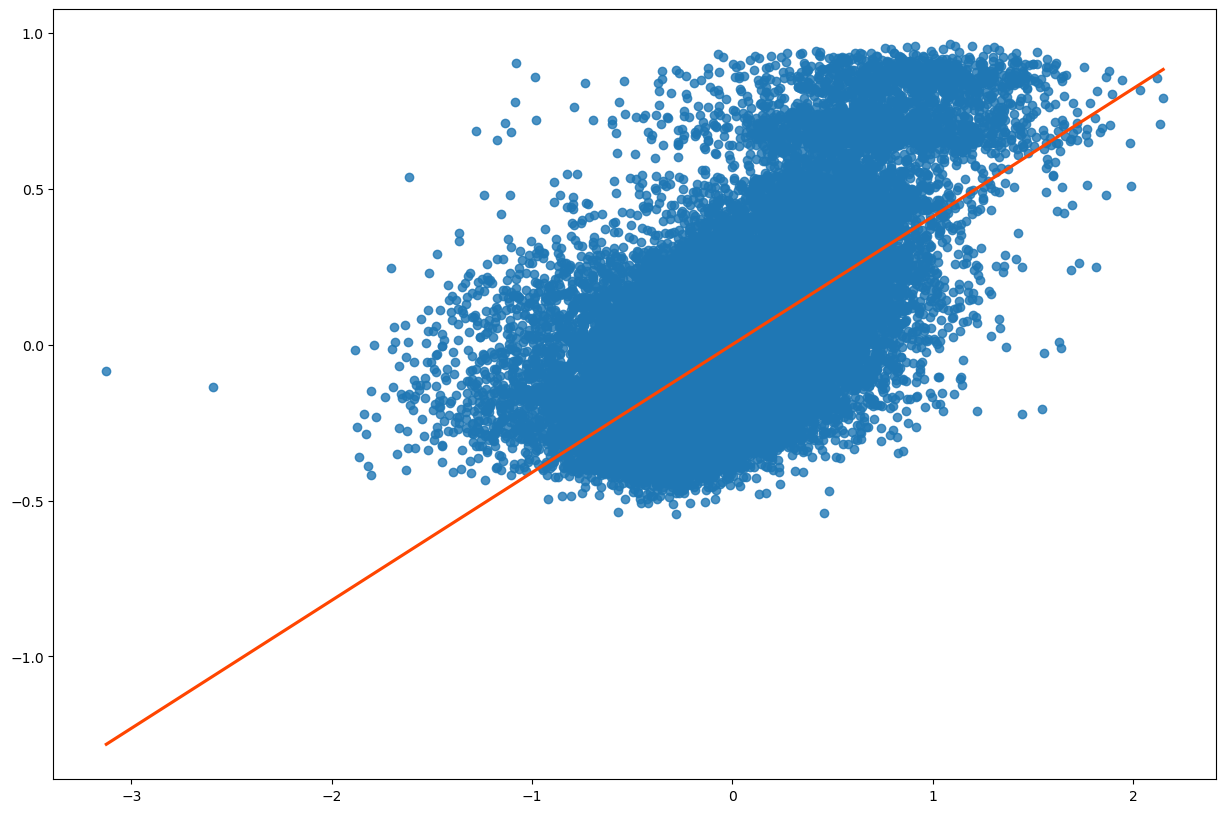

In [60]:
# Could this be an alternative (From Practical 6; basically a Moran's I plot of the model residuals)

lag_residual = weights.spatial_lag.lag_spatial(w, model1.u)
seaborn.regplot(
    x=model1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color='orangered'),
    ci=None,
)

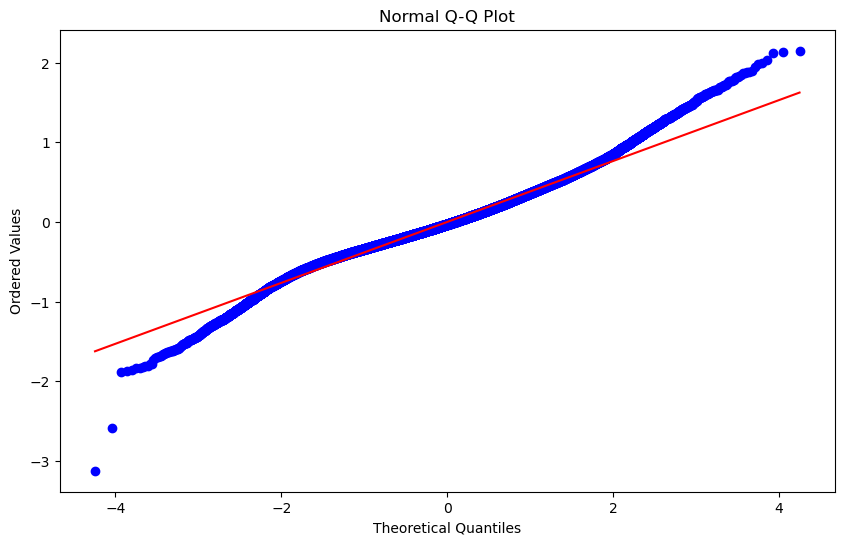

In [96]:
# QQ plot
plt.figure(figsize=(10, 6))
stats.probplot(model1.u.flatten(), dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()


In [36]:
# checking multicollinearity
def check_multicollinearity(df, features):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(len(features))]
    print(vif_data)
    
check_multicollinearity(hp_with_school_dist2, dist_names)


       Feature        VIF
0     log_area  30.477015
1  numberrooms  20.418478
2        Flats   2.838240
3     Detached   1.192107
4          New   1.006695
5  Dist_School   4.249237


In [62]:
# spatial autocorrelation analysis 
def spatial_autocorrelation_analysis(residuals, spatial_weights):
    # Moran's I (Standardised Spatial CoVariance)
    moran = esda.Moran(residuals, spatial_weights)
    print("Moran's I:", moran.I)
    print("Moran's p-value:", moran.p_sim)
    
residuals = model1.u
spatial_weights = w
spatial_autocorrelation_analysis(residuals, spatial_weights)

Moran's I: 0.4106204531735166
Moran's p-value: 0.001


In [64]:
# Geary's C (Sum of Squared Distances) 
geary = esda.Geary(residuals, spatial_weights)
print("Geary's C:", geary.C)
print("Geary's p-value:", geary.p_sim)

Geary's C: 0.5905057146255315
Geary's p-value: 0.001


<Figure size 1200x800 with 0 Axes>

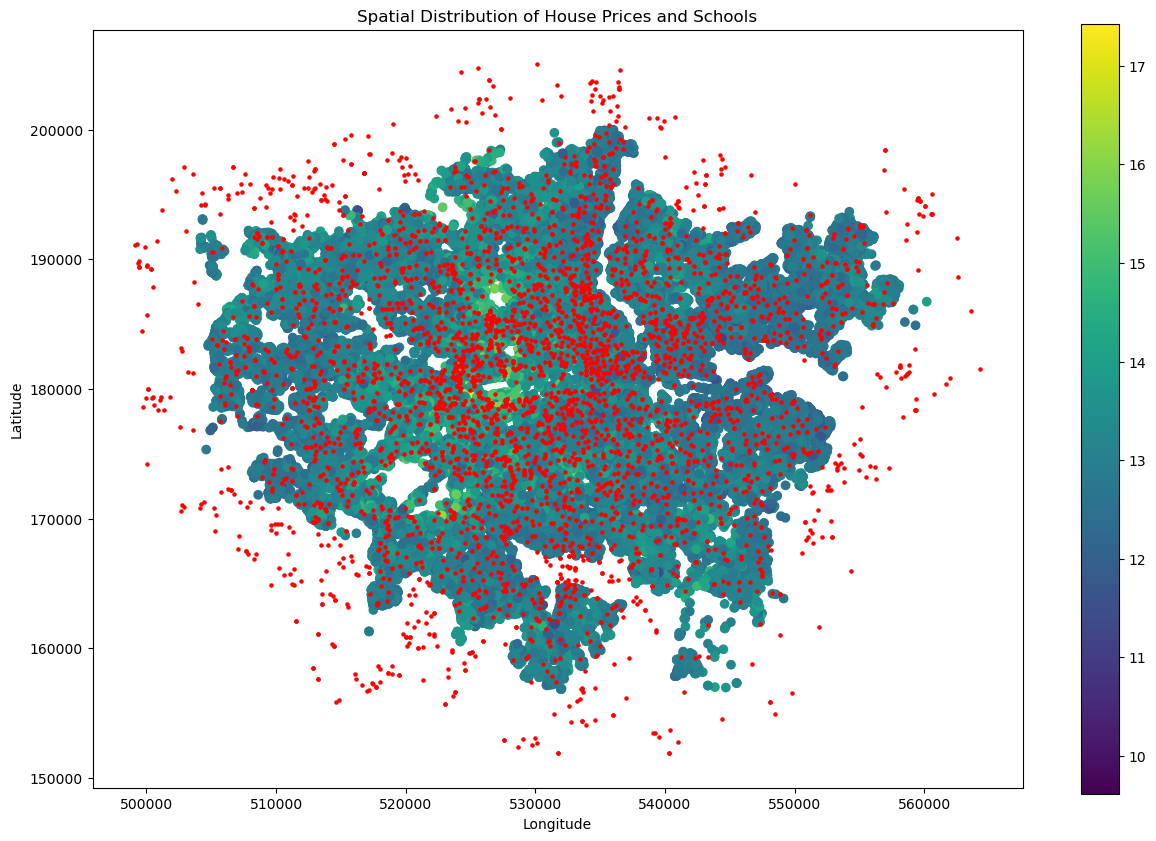

In [49]:
# Additional variable exploration and model improvement can be done here

# Visualization of spatial patterns
# Example: Plotting house prices and schools on a map
plt.figure(figsize=(12, 8))
hp_with_school_dist2.plot(column='log_price', cmap='viridis', legend=True)
schools.plot(marker='o', color='red', markersize=5, ax=plt.gca())
plt.title('Spatial Distribution of House Prices and Schools')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Model 2: Fixed Effects Model (same predictors as Model 1)


In [95]:
lag_residual = weights.spatial_lag.lag_spatial(w, model2.resid)
seaborn.regplot(
    x=model2.resid,
    y=lag_residual.flatten(),
    line_kws=dict(color='orangered'),
    ci=None,
)


ValueError: dimension mismatch

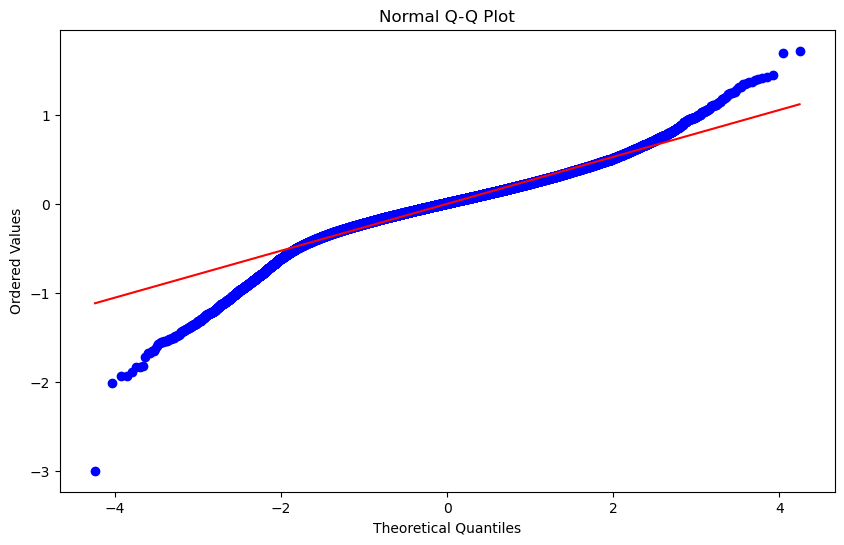

In [72]:
# QQ plot
plt.figure(figsize=(10, 6))
stats.probplot(model2.resid, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()


In [73]:
# spatial autocorrelation analysis 
def spatial_autocorrelation_analysis(residuals, spatial_weights):
    # Moran's I (Standardised Spatial CoVariance)
    moran = esda.Moran(residuals, spatial_weights)
    print("Moran's I:", moran.I)
    print("Moran's p-value:", moran.p_sim)
    
residuals = model2.resid
spatial_weights = w
spatial_autocorrelation_analysis(residuals, spatial_weights)

ValueError: dimension mismatch

In [ ]:
# Geary's C (Sum of Squared Distances) 
geary = esda.Geary(residuals, spatial_weights)
print("Geary's C:", geary.C)
print("Geary's p-value:", geary.p_sim)

#### Model 3: Model 1 but added in distance to schools as an additional predictor

<Axes: >

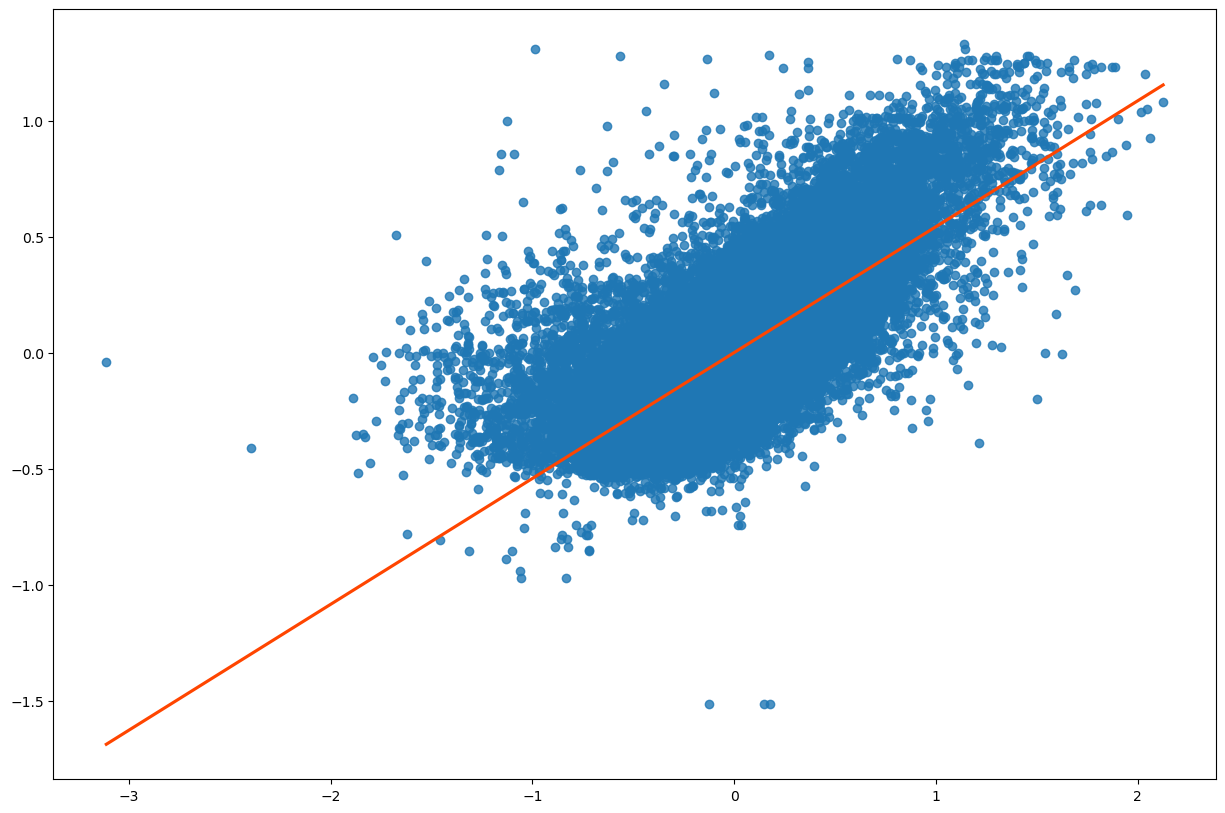

In [74]:
lag_residual = weights.spatial_lag.lag_spatial(w, model3.u)
seaborn.regplot(
    x=model3.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color='orangered'),
    ci=None,
)


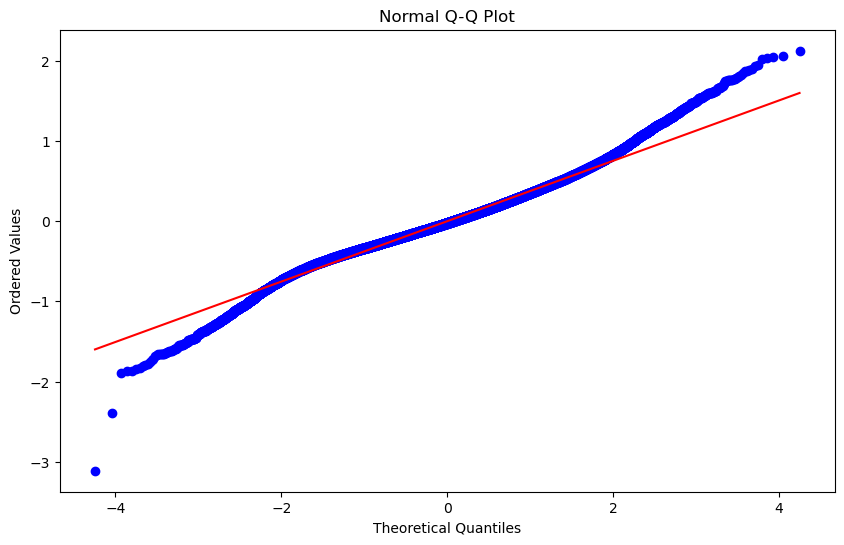

In [82]:
# QQ plot
plt.figure(figsize=(10, 6))
stats.probplot(model3.u.flatten(), dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()

In [76]:
# spatial autocorrelation analysis 
def spatial_autocorrelation_analysis(residuals, spatial_weights):
    # Moran's I (Standardised Spatial CoVariance)
    moran = esda.Moran(residuals, spatial_weights)
    print("Moran's I:", moran.I)
    print("Moran's p-value:", moran.p_sim)
    
residuals = model3.u
spatial_weights = w
spatial_autocorrelation_analysis(residuals, spatial_weights)

Moran's I: 0.5430600729550673
Moran's p-value: 0.001


In [77]:
# Geary's C (Sum of Squared Distances) 
geary = esda.Geary(residuals, spatial_weights)
print("Geary's C:", geary.C)
print("Geary's p-value:", geary.p_sim)

Geary's C: 0.4562423272515656
Geary's p-value: 0.001


#### Model 4: Spatial Lag of X Model

<Axes: >

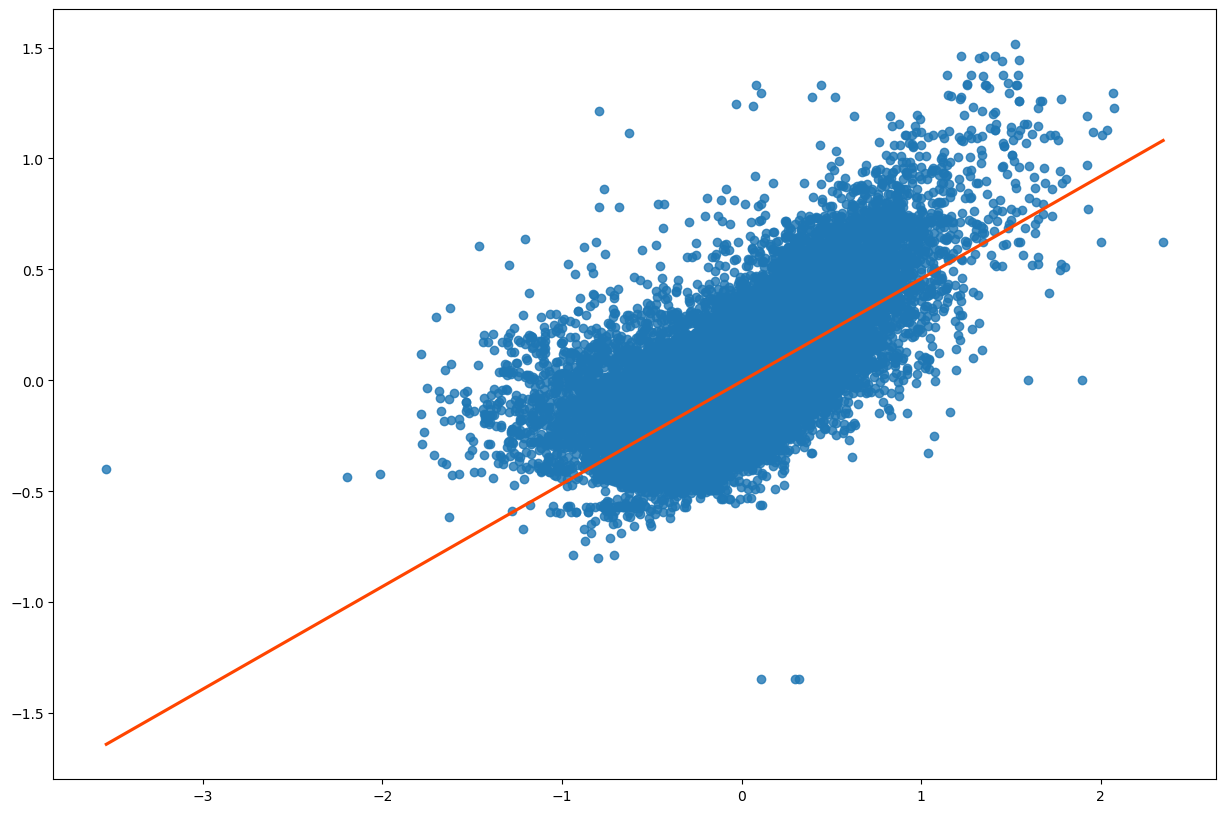

In [79]:
lag_residual = weights.spatial_lag.lag_spatial(w, model4.u)
seaborn.regplot(
    x=model4.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color='orangered'),
    ci=None,
)


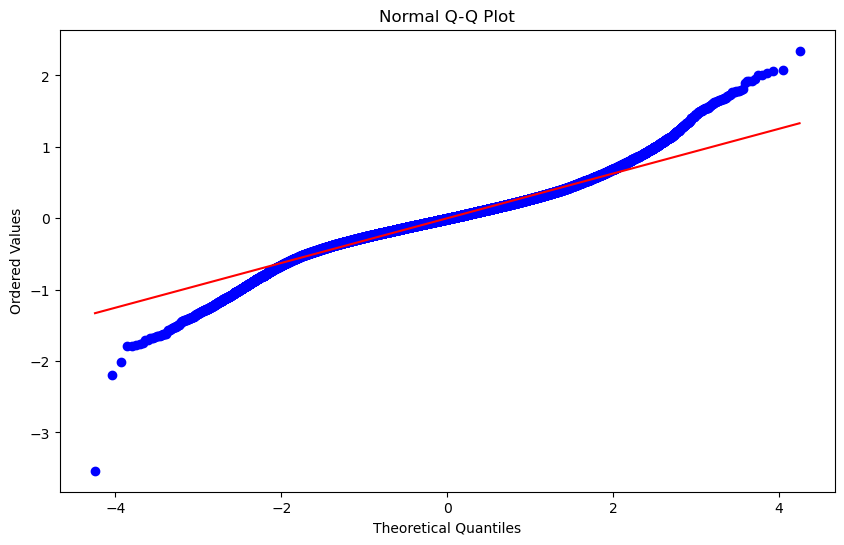

In [81]:
# QQ plot
plt.figure(figsize=(10, 6))
stats.probplot(model4.u.flatten(), dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()

In [83]:
# spatial autocorrelation analysis 
def spatial_autocorrelation_analysis(residuals, spatial_weights):
    # Moran's I (Standardised Spatial CoVariance)
    moran = esda.Moran(residuals, spatial_weights)
    print("Moran's I:", moran.I)
    print("Moran's p-value:", moran.p_sim)
    
residuals = model4.u
spatial_weights = w
spatial_autocorrelation_analysis(residuals, spatial_weights)

Moran's I: 0.46283351166119346
Moran's p-value: 0.001


In [84]:
# Geary's C (Sum of Squared Distances) 
geary = esda.Geary(residuals, spatial_weights)
print("Geary's C:", geary.C)
print("Geary's p-value:", geary.p_sim)

Geary's C: 0.5311164040841557
Geary's p-value: 0.001


#### Model 5: Spatial Lag Model

<Axes: >

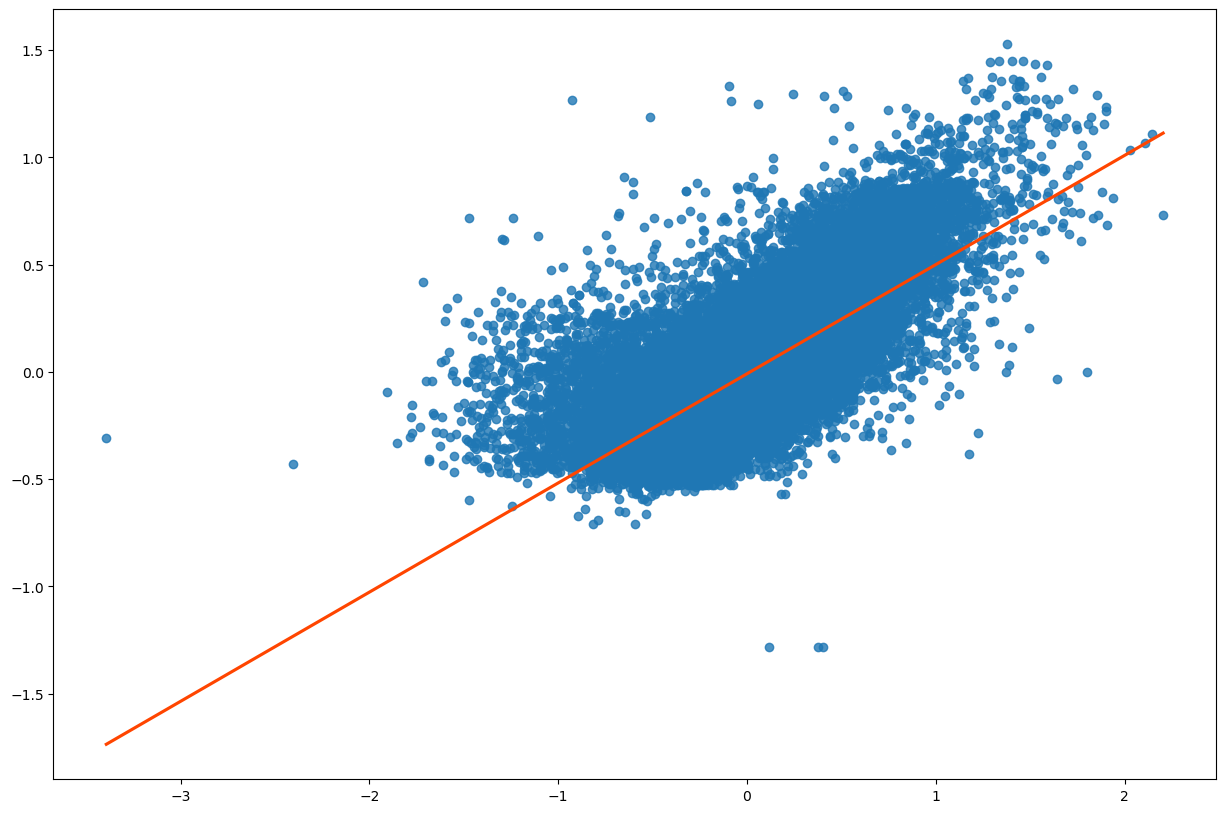

In [85]:
lag_residual = weights.spatial_lag.lag_spatial(w, model5.u)
seaborn.regplot(
    x=model5.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color='orangered'),
    ci=None,
)

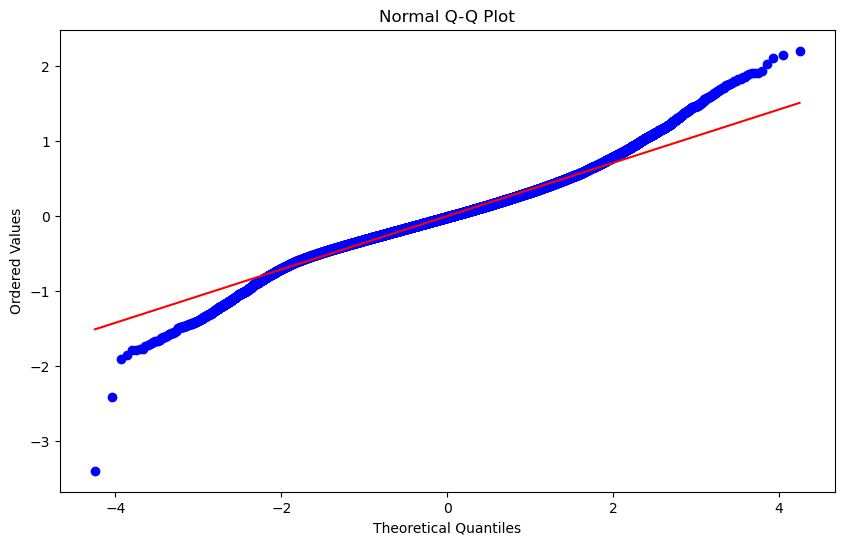

In [86]:
# QQ plot
plt.figure(figsize=(10, 6))
stats.probplot(model5.u.flatten(), dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()

In [87]:
# spatial autocorrelation analysis 
def spatial_autocorrelation_analysis(residuals, spatial_weights):
# Moran's I (Standardised Spatial CoVariance)
    moran = esda.Moran(residuals, spatial_weights)
    print("Moran's I:", moran.I)
    print("Moran's p-value:", moran.p_sim)
    
residuals = model5.u
spatial_weights = w
spatial_autocorrelation_analysis(residuals, spatial_weights)

Moran's I: 0.5093872369933444
Moran's p-value: 0.001


In [88]:
# Geary's C (Sum of Squared Distances) 
geary = esda.Geary(residuals, spatial_weights)
print("Geary's C:", geary.C)
print("Geary's p-value:", geary.p_sim)

Geary's C: 0.4866593899326345
Geary's p-value: 0.001


#### Model 6: Spatial Error Model (lambda was not significant, so this model is ruled out anyway, I think)